<a href="https://colab.research.google.com/github/ilayFriedman/deepLearningAss2/blob/master/task_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math

from keras.utils import to_categorical
from keras.layers import Input, Embedding, dot, add, Flatten, concatenate, Dropout, Dense,BatchNormalization
from keras.regularizers import l2
from keras.models import Model,Sequential
from keras.engine.saving import model_from_json


from keras.optimizers import Adam
from keras.layers import Flatten,Dense,LSTM,TimeDistributed,Input, TimeDistributed
from sklearn.metrics import confusion_matrix,accuracy_score,log_loss
import seaborn as sns


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


Sets consts:

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
IDs = [1,2,3,4,5,6,7,8,9]
train_ids = [1,2,3,4,5,6,9]
test_ids = [7,8]
activityIDdict = {0: 'transient',
              1: 'lying',
              2: 'sitting',
              3: 'standing',
              4: 'walking',
              5: 'running',
              6: 'cycling',
              7: 'Nordic_walking',
              9: 'watching_TV',
              10: 'computer_work',
              11: 'car driving',
              12: 'ascending_stairs',
              13: 'descending_stairs',
              16: 'vacuum_cleaning',
              17: 'ironing',
              18: 'folding_laundry',
              19: 'house_cleaning',
              20: 'playing_soccer',
              24: 'rope_jumping' }

colNames = ["timestamp", "activityID","heartrate"]

IMUhand = ['handTemperature',
           'handAcc16_1', 'handAcc16_2', 'handAcc16_3',
           'handAcc6_1', 'handAcc6_2', 'handAcc6_3',
           'handGyro1', 'handGyro2', 'handGyro3',
           'handMagne1', 'handMagne2', 'handMagne3',
           'handOrientation1', 'handOrientation2', 'handOrientation3', 'handOrientation4']

IMUchest = ['chestTemperature',
           'chestAcc16_1', 'chestAcc16_2', 'chestAcc16_3',
           'chestAcc6_1', 'chestAcc6_2', 'chestAcc6_3',
           'chestGyro1', 'chestGyro2', 'chestGyro3',
           'chestMagne1', 'chestMagne2', 'chestMagne3',
           'chestOrientation1', 'chestOrientation2', 'chestOrientation3', 'chestOrientation4']

IMUankle = ['ankleTemperature',
           'ankleAcc16_1', 'ankleAcc16_2', 'ankleAcc16_3',
           'ankleAcc6_1', 'ankleAcc6_2', 'ankleAcc6_3',
           'ankleGyro1', 'ankleGyro2', 'ankleGyro3',
           'ankleMagne1', 'ankleMagne2', 'ankleMagne3',
           'ankleOrientation1', 'ankleOrientation2', 'ankleOrientation3', 'ankleOrientation4']
columns = colNames + IMUhand + IMUchest + IMUankle
drive_path = '/content/drive/My Drive/deep_learning_ass2/PAMAP2_Dataset/Protocol'

data loading functions

In [0]:
def plot_hisotry(history):
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'validation'], loc='upper left')
  plt.show()
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'validation'], loc='upper left')
  plt.show()

def confusion_matrix_predict(model, X_test, y_test):
    preds = model.predict(X_test)
    # print (predicts.shape)
    # print(y_test.shape)
    predicts = np.argmax(preds, axis=1) #return the predicted category in each sample in test set
    y_test = np.argmax(y_test, axis=1)
    print(confusion_matrix(y_test,predicts))
    print('model accuracy on test set is: {}%'.format(accuracy_score(y_test,predicts)*100))
    sns.heatmap(confusion_matrix(y_test,predicts),cmap='Greens',annot=False, fmt='d')
    plt.xlabel('Prediction')
    plt.ylabel('True label')
    plt.title('Classification results on test set')
    print()
    counter = 0
    for i in range(10000):
      if (predicts[i] != y_test[i]):
          print ("x_data")
          print (X_test[i])
          print ("y_data")
          print (y_test[i])
          print("predict data")
          print (predicts[i])
          counter = counter+1
        
      if(counter==5):
          break
          
 
def save_model(model, model_name):
    model_json = model.to_json()
    with open(model_name + ".json", "w") as json_file:
        json_file.write(model_json)
    model.save_weights(model_name + ".h5")


def load_model(model_name):
    json_file = open(model_name + '.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    loaded_model.load_weights(model_name + ".h5")
    return loaded_model

In [0]:
# path_to_file = 'subject10{}.dat'
path_to_file = drive_path+'/subject10{}.dat'

def load_train_data(columns,prepare_data):
    train_data = None
    train_target = None
    for i in train_ids:
        if train_data is None:
            train_data = pd.read_csv(path_to_file.format(i), delim_whitespace=True, header=None, names=columns)
            df_train = pd.DataFrame(data=train_data)
            df_train, train_target = prepare_data(df_train,'subject10{}'.format(i))

        else:
            train_data = pd.read_csv(path_to_file.format(i), delim_whitespace=True, header=None, names=columns)
            df_load_train = pd.DataFrame(data=train_data)
            df_load_train, train_load_target = prepare_data(df_load_train,'subject10{}'.format(i))
            df_train = np.concatenate((df_train, df_load_train))
            train_target = np.concatenate((train_target, train_load_target))

    df_train = pd.DataFrame(data = df_train)
   
    df_train = df_train.rename(columns={40:"subject", 41:"act"})
    train_target = pd.DataFrame(data = train_target)
    train_target = train_target.rename(columns={0: "act", 1:"subject"})
    print("train")
    print(df_train.head(5))
    print("train target")
    print(train_target.head(5))
    return df_train, train_target

def load_val_data(columns, prepare_data):
    val_data = pd.read_csv(path_to_file.format(7), delim_whitespace=True, header=None, names=columns)

    df_val = pd.DataFrame(data=val_data)
    df_val, val_target = prepare_data(df_val,'subject107')
   
    df_val = df_val.rename(columns={40:"subject", 41:"act"})
    val_target = val_target.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    print ("validation")
    print (df_val.head(5))
    return df_val, val_target

def load_test_data(columns, prepare_data):
    
    test_data = None
    test_target = None
    for i in test_ids:
        if test_data is None:
            test_data = pd.read_csv(path_to_file.format(i), delim_whitespace=True, header=None, names=columns)
            df_test = pd.DataFrame(data=test_data)
            df_test, test_target = prepare_data(df_test,'subject10{}'.format(i))

        else:
            test_data = pd.read_csv(path_to_file.format(i), delim_whitespace=True, header=None, names=columns)
            df_load_test = pd.DataFrame(data=test_data)
            df_load_test, test_load_target = prepare_data(df_load_test,'subject10{}'.format(i))
            df_test = np.concatenate((df_test, df_load_test))
            test_target = np.concatenate((test_target, test_load_target))

    df_test = pd.DataFrame(data = df_test)
   
    df_test = df_test.rename(columns={40:"subject", 41:"act"})
    test_target = pd.DataFrame(data = test_target)
    test_target = test_target.rename(columns={0: "act", 1:"subject"})

    print ("test")
    print (df_test.head(5))
    return df_test, test_target

Data Prepering:
droping the timestamp, removing activity num 0, and seting the target column to be "activityID"

In [0]:
def prepare_data(df,subject_name):
    df_copy = df.copy()
    df_copy.drop(['timestamp'], axis=1, inplace=True)
    df_copy = df_copy[(df_copy['activityID'] != 0)]
    df_copy.drop([x for x in df_copy.columns if 'Ori' in x], axis=1, inplace=True)
    df_copy.interpolate(method ='linear', limit_direction ='forward', inplace=True) 
    df_copy.dropna(inplace=True)
    df_copy['subject'] = int(subject_name[-2:])
    df_copy['act'] = df_copy['activityID']
    # df_copy = df_copy.rename(columns={2: "HR"})
    target = df_copy.iloc[:,0:1]
    target['subject'] = int(subject_name[-2:])
    df_copy.drop(['activityID'], axis=1, inplace=True)
    # data is given every 0.01s and the sampling frequency of the HR-monitor was only approximately 9Hz
    return df_copy,target

loading the first data

In [8]:
train, train_target = load_train_data(columns, prepare_data)
test, test_target = load_test_data(columns, prepare_data)
print(train.shape)
print(train_target.shape)
print(test.shape)
print(test_target.shape)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


train
       0       1        2        3  ...       38       39  subject  act
0  100.0  30.375  2.30106  7.25857  ... -37.1225 -57.8847      1.0  1.0
1  100.0  30.375  2.07165  7.25965  ... -36.9744 -57.7501      1.0  1.0
2  100.0  30.375  2.41148  7.59780  ... -36.9632 -57.9957      1.0  1.0
3  100.0  30.375  2.32815  7.63431  ... -36.1724 -59.3487      1.0  1.0
4  100.0  30.375  2.25096  7.78598  ... -37.1744 -58.1199      1.0  1.0

[5 rows x 42 columns]
train target
   act  subject
0    1        1
1    1        1
2    1        1
3    1        1
4    1        1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


test
      0        1        2        3  ...       38       39  subject  act
0  80.0  30.1875 -9.50909  2.71323  ... -43.1971 -1.70813      7.0  1.0
1  80.0  30.1875 -9.54902  2.59937  ... -43.4489 -1.85010      7.0  1.0
2  80.0  30.1875 -9.43084  2.71332  ... -42.7840 -1.28492      7.0  1.0
3  80.0  30.1875 -9.31640  2.86420  ... -43.3136 -1.85072      7.0  1.0
4  80.0  30.1875 -9.32068  2.82525  ... -43.8285 -1.56641      7.0  1.0

[5 rows x 42 columns]
(1447957, 42)
(1447957, 2)
(494873, 42)
(494873, 2)


In [0]:
def get_50_observations(df, target, ids, num_steps = 50):
    features_check = df.shape[1]-2
    categories = 25
    length  = math.floor(len(df)/50)
 
    x = np.zeros((length, num_steps, features_check))
    y = np.zeros((length, categories))
   
    skip_step = 50

    i=0
    while i<len(df):
        subject_df =  pd.DataFrame(columns=range(df.shape[1]))
        subject_target = pd.DataFrame(columns=['act'])
        for j in ids:
            subject_df = df.loc[df['subject'] == j].reset_index(drop=True)
            subject_df = subject_df.rename(columns={40:"subject", 41:"act"})
            subject_target = target.loc[target['subject'] == j].reset_index(drop=True)
            k = 0
            while k < len(subject_df):
                if k+num_steps>=len(subject_df):
                  break
                temp_x = subject_df.iloc[k:(k + num_steps), :]
                while temp_x['act'].nunique() != 1: 
                    k = k + 1
                    temp_x = subject_df.iloc[k:(k + num_steps), :]
                x[i, :, :] = subject_df.iloc[k:(k + num_steps), 0:features_check]
                temp_y = subject_target.iloc[k:(k + num_steps),0:1].max()
                y[i, :] = to_categorical(temp_y, num_classes=categories)
                k = k + skip_step
                i = i + 1
        break

    return x[:i],y[:i]

In [10]:
prepare_train_x, prepare_train_y = get_50_observations(train, train_target, train_ids)
prepare_test_x, prepare_test_y = get_50_observations(test, test_target, test_ids)

KeyboardInterrupt: ignored

In [0]:
print (prepare_train_x.shape)
print (prepare_train_y.shape)
print (prepare_test_x.shape)
print (prepare_test_y.shape)


### Naïve baseline solution

In [92]:
# print(train_target['act'])
classes_train_num = train_target['act'].value_counts()
# print((classes_train_num/classes_train_num.sum()).idxmax())
max_probability_action = (classes_train_num/classes_train_num.sum()).idxmax()
print("Action with max probability: " + str(max_probability_action) + " - " + activityIDdict[max_probability_action])

train_predictions = train_target.copy()
train_predictions['act'] = max_probability_action
diff_train = pd.DataFrame((train_predictions != train_target).any(1))[0].value_counts()
error_vals = diff_train[1]
true_vals = diff_train[0]
train_accurecy = true_vals/(true_vals + error_vals)
print ("Accurecy on train:")
print (str(train_accurecy * 100) + "%")

test_predictions = test_target.copy()
test_predictions['act'] = max_probability_action
diff_test = pd.DataFrame((test_predictions != test_target).any(1))[0].value_counts()
error_vals = diff_test[1]
true_vals = diff_test[0]
test_accurecy = true_vals/(true_vals + error_vals)
print ("Accurecy on test:")
print (str(test_accurecy * 100) + "%")

Action with max probability: 17 - ironing
Accurecy on train:
12.168938718484043%
Accurecy on test:
12.627280130457713%


## Classical machine learning model 

In [110]:
from sklearn.linear_model import LogisticRegression

lrc = LogisticRegression(n_jobs=8,solver='lbfgs',multi_class='auto')
lrc.fit(train, train_target['act'])


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=8, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

[[26399 21937   476     6     0     0     0     0     0   929    24     0]
 [    0 26332  6929   486     0     0     0     0   896   549    13     0]
 [    0 10318 40141   443     0     0     0     2     0     6     1     0]
 [ 1211   169  3754 55681     0    26   966   569  1224   889   764     0]
 [   70   238   825  2551  5666   124   616  2395  6361   157   117  1104]
 [    6     0     0   417     2 43222  1240   301  1720  1242     5     0]
 [  158  1253   321  1904   963   471 24188  4284 23539   154   378     0]
 [  433   994  2340  4723   133    31  4303 11803  1673  2495   155   246]
 [  626   449  2374  6161   586    28   845  5689  3091   964   271   189]
 [  131  1264  1174  4527     0  3088     1   147  2591 29309  3612     0]
 [  613  5674 28122    34     0     0     0     0     0   161 27885     0]
 [    1     0     0   103   719   194   157  1334  2852    44     7  3395]]

model accuracy on test set is: 60.03802995920166%



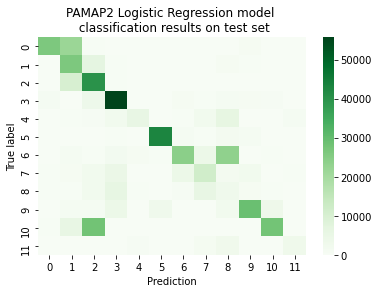

In [111]:
preds = lrc.predict(test_x)

pred_cat = preds
print(confusion_matrix(test_target['act'],pred_cat))
print()
print('model accuracy on test set is: {}%'.format(accuracy_score(test_target['act'],pred_cat)*100))
sns.heatmap(confusion_matrix(test_target['act'],pred_cat),cmap='Greens',annot=False, fmt='d')
plt.xlabel('Prediction')
plt.ylabel('True label')
plt.title('PAMAP2 Logistic Regression model \n classification results on test set')
print()

## Neural network model

In [0]:
def create_model(steps, num_of_features):
  model = Sequential()
  model.add(LSTM(200, input_shape=(steps, num_of_features), return_sequences=True))
  model.add(LSTM(200, return_sequences=False))
  model.add(Dense(100))
  model.add(Dense(50))
  model.add(BatchNormalization())
  model.add(Dense(25,activation='softmax'))
  model.summary()
  return model


In [11]:

model = create_model(50, train.shape[1]-2)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history  = model.fit(prepare_train_x, prepare_train_y, epochs=20, batch_size=1024, validation_split=0.2)
save_model(model, "firstInMorning")
plot_hisotry (history)
confusion_matrix_predict(model, prepare_test_x, prepare_test_y )

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50, 200)           192800    
_________________________________________________________________
lstm_2 (LSTM)                (None, 200)               320800    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               20100     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
batch_normalization_1 (Batch (None, 50)                200       
_________________________________________________________________
dense_3 (Dense)              (None, 25)                1275      
Total params: 540,225
Trainable params: 540,125
Non-trainable params: 100
______________________________________________

NameError: ignored

## Self-Supervised Tasks

In [0]:
from sklearn.preprocessing import LabelBinarizer

def prepare_data_self_super(df,subject_name):
    df_copy = df.copy()
    df_copy.drop(['timestamp'], axis=1, inplace=True)
    df_copy = df_copy[(df_copy['activityID'] != 0)]
    df_copy.drop([x for x in df_copy.columns if 'Ori' in x], axis=1, inplace=True)
    df_copy.interpolate(method ='linear', limit_direction ='forward', inplace=True) 
    df_copy.dropna(inplace=True)
    df_copy['subject'] = int(subject_name[-2:])
    df_copy['act'] = df_copy['heartrate']
    target = df_copy.iloc[:,1:2]
    target['subject'] = int(subject_name[-2:])
    df_copy.drop(['heartrate'], axis=1, inplace=True)

    # data is given every 0.01s and the sampling frequency of the HR-monitor was only approximately 9Hz
    return df_copy,target

def get_50_observations_self_super(df, target, ids):
    features_check = df.shape[1]-2
    categories = 25
    num_steps = 50
    length  = math.floor(len(df)/50)
 
    x = np.zeros((length, num_steps, features_check))
    y = np.zeros((length, 1))
   
    skip_step = 50
    i=0
    while i<len(df):
        subject_df =  pd.DataFrame(columns=range(df.shape[1]))
        subject_target = pd.DataFrame(columns=['act'])
        for j in ids:
            subject_df = df.loc[df['subject'] == j].reset_index(drop=True)
            subject_df = subject_df.rename(columns={40:"subject", 41:"act"})
            subject_target = target.loc[target['subject'] == j].reset_index(drop=True)
            k = 0
            while k < len(subject_df):
                if k+num_steps>=len(subject_df):
                  break
                temp_x = subject_df.iloc[k:(k + num_steps), :]
                while temp_x['act'].nunique() != 1: 
                    k = k + 1
                    temp_x = subject_df.iloc[k:(k + num_steps), :]
                if k+num_steps>=len(subject_df):
                  break
                x[i, :, :] = subject_df.iloc[k:(k + num_steps), 0:features_check]
                temp_y = subject_target.iloc[k:(k + num_steps),0:1].max()
                y[i, :] = temp_y
                k = k + num_steps
                i = i + 1
        break

    return x[:i],y[:i]

In [160]:
ss_df_train, ss_train_target = load_train_data(columns, prepare_data_self_super)
ss_df_test, ss_test_target = load_test_data(columns, prepare_data_self_super)

train
     0       1        2        3  ...       38       39  subject    act
0  1.0  30.375  2.30106  7.25857  ... -37.1225 -57.8847      1.0  100.0
1  1.0  30.375  2.07165  7.25965  ... -36.9744 -57.7501      1.0  100.0
2  1.0  30.375  2.41148  7.59780  ... -36.9632 -57.9957      1.0  100.0
3  1.0  30.375  2.32815  7.63431  ... -36.1724 -59.3487      1.0  100.0
4  1.0  30.375  2.25096  7.78598  ... -37.1744 -58.1199      1.0  100.0

[5 rows x 42 columns]
train target
     act  subject
0  100.0      1.0
1  100.0      1.0
2  100.0      1.0
3  100.0      1.0
4  100.0      1.0
test
     0        1        2        3  ...       38       39  subject   act
0  1.0  30.1875 -9.50909  2.71323  ... -43.1971 -1.70813      7.0  80.0
1  1.0  30.1875 -9.54902  2.59937  ... -43.4489 -1.85010      7.0  80.0
2  1.0  30.1875 -9.43084  2.71332  ... -42.7840 -1.28492      7.0  80.0
3  1.0  30.1875 -9.31640  2.86420  ... -43.3136 -1.85072      7.0  80.0
4  1.0  30.1875 -9.32068  2.82525  ... -43.8285 -1.56

In [0]:
ss_df_train, ss_train_target = get_50_observations_self_super(ss_df_train, ss_train_target,train_ids)
ss_df_test, ss_test_target = get_50_observations_self_super(ss_df_test, ss_test_target, test_ids)
print(ss_df_train)
print(ss_train_target)
print(ss_df_test)
print(ss_test_target)

In [164]:
num_features_ss = 40
num_steps = 50
model_ss = Sequential()
model_ss.add(LSTM(200, input_shape=(num_steps, num_features_ss), return_sequences=True, activation = 'relu'))
model_ss.add(LSTM(200, return_sequences=False))
model_ss.add(Dense(100))
model_ss.add(Dense(50))
model.add(BatchNormalization())
model_ss.add(Dense(1,activation='relu'))

model_ss.summary()
model_ss.compile(loss='mse',optimizer='adam',metrics=['mae'])
history_ss  = model_ss.fit(ss_df_train, ss_train_target, epochs=20, batch_size=1024, validation_split=0.2)

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_41 (LSTM)               (None, 50, 200)           192800    
_________________________________________________________________
lstm_42 (LSTM)               (None, 200)               320800    
_________________________________________________________________
dense_55 (Dense)             (None, 100)               20100     
_________________________________________________________________
dense_56 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_57 (Dense)             (None, 1)                 51        
Total params: 538,801
Trainable params: 538,801
Non-trainable params: 0
_________________________________________________________________
Train on 20500 samples, validate on 5125 samples
Epoch 1/20
20500/20500 [==============================] - 94s 5m

In [0]:
save_model(model_ss, "ss_model")

In [0]:
def visual_results(history):
  plt.plot(history.history['mae'])
  plt.plot(history.history['val_mae'])
  plt.title('Model MAE')
  plt.ylabel('MAE')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()

  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()

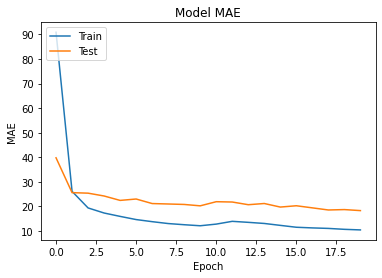

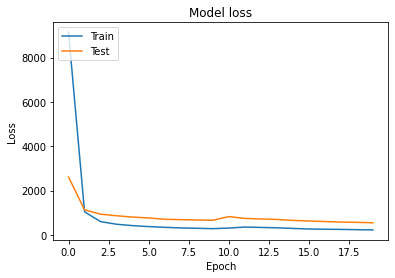

MAE for heartrate prediction: 677.2088356929528


In [169]:
from sklearn.metrics import mean_squared_error
test_preds = model_ss.predict(np.stack(ss_df_test,axis=0))
test_targets = ss_test_target
visual_results(history_ss)
print("MAE for heartrate prediction: " + str(mean_squared_error(test_targets,test_preds)))


In [171]:
for layer in model_ss.layers:
    layer.trainable = False
    
x = model_ss.layers[-2].output
x = Dense(25, activation="softmax")(x)

new_model = Model(inputs = model_ss.input, outputs = x)

new_model.summary()
new_model.compile(loss = "categorical_crossentropy", optimizer = 'adam', metrics=["accuracy"])
history_transfer_model  = new_model.fit(prepare_train_x, prepare_train_y, epochs=50, batch_size=512, validation_split=0.2)

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_41_input (InputLayer)   (None, 50, 40)            0         
_________________________________________________________________
lstm_41 (LSTM)               (None, 50, 200)           192800    
_________________________________________________________________
lstm_42 (LSTM)               (None, 200)               320800    
_________________________________________________________________
dense_55 (Dense)             (None, 100)               20100     
_________________________________________________________________
dense_56 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_59 (Dense)             (None, 25)                1275      
Total params: 540,025
Trainable params: 1,275
Non-trainable params: 538,750
_________________________________________________

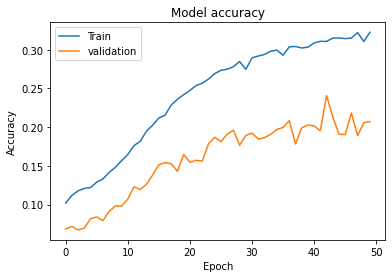

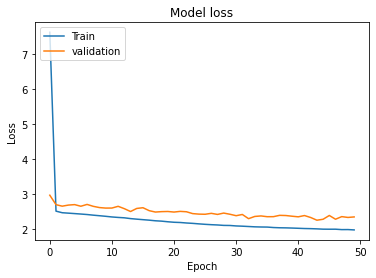

[[563 345   8  22   0   5   0   2   1  14  35   0]
 [160 161  13  66   0   0   0   0   3  25 275   0]
 [ 84 252  90 126   0   4   0  16   1 114 331   0]
 [ 82 254 106 316   0  40   2  35  18 234 217   0]
 [106  50  10  63   0   7   1   7  17  45  97   0]
 [ 93  86   9 239   0 101   0  28  17 298  91   0]
 [157 197  35 207   0  30   0  42  24 165 294   0]
 [ 66  79  28 137   0  26   2  29  21 114  83   0]
 [ 33  56  44 100   0  22   1  13  19  69  66   0]
 [ 91 126  36 189   0  36   3  25   5 173 232   0]
 [167 375  47 152   0   8   5   4  24 140 326   0]
 [ 55  32   1  18   0   9   0   2   5  17  37   0]]
model accuracy on test set is: 17.988668555240793%

x_data
[[ 80.       30.1875   -9.50909 ... -53.4549  -43.1971   -1.70813]
 [ 80.       30.1875   -9.54902 ... -53.5788  -43.4489   -1.8501 ]
 [ 80.       30.1875   -9.43084 ... -53.9694  -42.784    -1.28492]
 ...
 [ 80.       30.1875   -9.24349 ... -53.6936  -43.8281   -1.42457]
 [ 80.       30.1875   -9.39893 ... -53.3178  -43.7194 

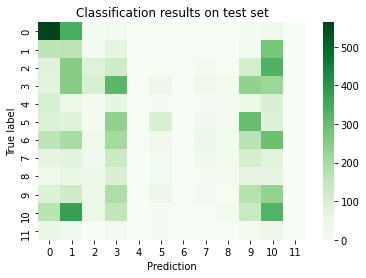

In [172]:
save_model(new_model, "ss_fit_model")
plot_hisotry (history_transfer_model)
confusion_matrix_predict(new_model, prepare_test_x, prepare_test_y )

## Improving the model

In [12]:
train_norm, train_target_norm = load_train_data(columns, prepare_data)
test_norm, test_target_norm = load_test_data(columns, prepare_data)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


train
       0       1        2        3  ...       38       39  subject  act
0  100.0  30.375  2.30106  7.25857  ... -37.1225 -57.8847      1.0  1.0
1  100.0  30.375  2.07165  7.25965  ... -36.9744 -57.7501      1.0  1.0
2  100.0  30.375  2.41148  7.59780  ... -36.9632 -57.9957      1.0  1.0
3  100.0  30.375  2.32815  7.63431  ... -36.1724 -59.3487      1.0  1.0
4  100.0  30.375  2.25096  7.78598  ... -37.1744 -58.1199      1.0  1.0

[5 rows x 42 columns]
train target
   act  subject
0    1        1
1    1        1
2    1        1
3    1        1
4    1        1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


test
      0        1        2        3  ...       38       39  subject  act
0  80.0  30.1875 -9.50909  2.71323  ... -43.1971 -1.70813      7.0  1.0
1  80.0  30.1875 -9.54902  2.59937  ... -43.4489 -1.85010      7.0  1.0
2  80.0  30.1875 -9.43084  2.71332  ... -42.7840 -1.28492      7.0  1.0
3  80.0  30.1875 -9.31640  2.86420  ... -43.3136 -1.85072      7.0  1.0
4  80.0  30.1875 -9.32068  2.82525  ... -43.8285 -1.56641      7.0  1.0

[5 rows x 42 columns]


In [14]:
train_norm = train_norm.astype('float32')
test_norm = test_norm.astype('float32')
mean_train = np.mean(train_norm, axis = 0)
std_train = np.std(train_norm, axis = 0)
train_norm_before = train_norm.copy()
train_norm_before = (train_norm_before-mean_train)/std_train
train_norm_before['subject'] = train_norm['subject']
train_norm_before['act'] = train_norm['act']
print(train_norm_before)
train_norm = train_norm_before
print(train_norm)

mean_test = np.mean(test_norm, axis = 0)
std_test = np.std(test_norm, axis = 0)
test_norm_before = test_norm.copy()
test_norm_before = (test_norm_before-mean_test)/std_test
test_norm_before['subject'] = test_norm['subject']
test_norm_before['act'] = test_norm['act']
print(test_norm_before)
test_norm = test_norm_before
print(test_norm)


                0         1         2  ...        39  subject   act
0       -0.335912 -1.188510  1.118412  ... -3.673743      1.0   1.0
1       -0.335912 -1.188510  1.082466  ... -3.667156      1.0   1.0
2       -0.335912 -1.188510  1.135714  ... -3.679176      1.0   1.0
3       -0.335912 -1.188510  1.122657  ... -3.745390      1.0   1.0
4       -0.335912 -1.188510  1.110562  ... -3.685254      1.0   1.0
...           ...       ...       ...  ...       ...      ...   ...
1447952  2.026600 -3.934668  1.540466  ... -0.849266      9.0  24.0
1447953  2.026600 -3.934668  1.545634  ... -0.814604      9.0  24.0
1447954  2.026600 -3.934668  1.551345  ... -0.814491      9.0  24.0
1447955  2.026600 -3.934668  1.563105  ... -0.807656      9.0  24.0
1447956  2.026600 -3.934668  1.542575  ... -0.856274      9.0  24.0

[1447957 rows x 42 columns]
                0         1         2  ...        39  subject   act
0       -0.335912 -1.188510  1.118412  ... -3.673743      1.0   1.0
1       -0.335912 -

In [0]:
train_x, train_y = get_50_observations(train_norm, train_target_norm, train_ids, 250)
test_x, test_y = get_50_observations(test_norm, test_target_norm, test_ids, 250)

In [13]:
print(train_x.shape)
print(train_x)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(28595, 250, 40)
[[[-0.33657786 -1.15042937  1.11815655 ... -1.44775414 -1.69519222
   -3.67317796]
  [-0.33657786 -1.15042937  1.0822134  ... -1.50668645 -1.68846583
   -3.66659188]
  [-0.33657786 -1.15042937  1.13545692 ... -1.51857591 -1.68795717
   -3.67860985]
  ...
  [-0.2603929  -1.11776125  0.61358041 ... -1.31496322 -1.90935946
   -3.70087385]
  [-0.2603929  -1.11776125  0.56705034 ... -1.32017517 -1.95421851
   -3.70740652]
  [-0.2603929  -1.11776125  0.59422439 ... -1.32044315 -1.94404042
   -3.71940446]]

 [[-0.2984854  -1.15042937  1.1143322  ... -1.51842356 -1.67838311
   -3.64216018]
  [-0.2984854  -1.15042937  1.16766024 ... -1.48373783 -1.67361426
   -3.70899653]
  [-0.2984854  -1.15042937  1.15678227 ... -1.49511755 -1.68852031
   -3.69091129]
  ...
  [-0.2603929  -1.11776125  0.33783203 ... -1.30331039 -1.92422462
   -3.74353313]
  [-0.2603929  -1.11776125  0.33262408 ... -1.33822739 -1.92375684
   -3.6948061 ]
  [-0.2603929  -1.11776125  0.32297435 ... -1.33225894 -

In [0]:
def create_model(steps, num_of_features):
  model = Sequential()
  model.add(LSTM(200, input_shape=(steps, num_of_features), return_sequences=True))
  model.add(LSTM(200, return_sequences=False))
  model.add(Dense(100))
  model.add(Dense(50))
  # model.add(BatchNormalization())
  model.add(Dense(25,activation='softmax'))
  model.summary()
  return model


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 250, 200)          192800    
_________________________________________________________________
lstm_2 (LSTM)                (None, 200)               320800    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               20100     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_3 (Dense)              (None, 25)                1275      
Total params: 540,025
Trainable params: 540,025
Non-trainable params: 0
_________________________________________________________________
Train on 22876 samples, validate on 5719 samples
Epoch 1/30
22876/22876 [==============================] - 530s 23

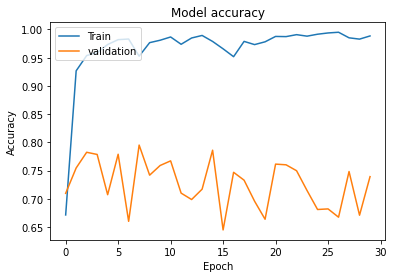

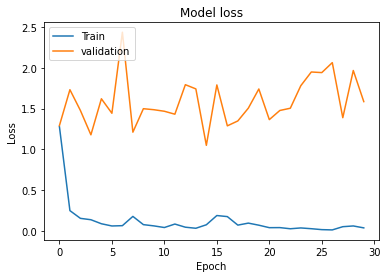

[[2794    6    0    0    0    0    0    2    0   12   12    0]
 [   0 2941   17    0    0    0    0    0    0    6    8    0]
 [   2    5 2413    0    0    0    0    0    0    3  331    0]
 [   7    0    0 3294    0    0    0   34  100    7    1    0]
 [   2    4    2   29 1174    8  232   19   26    1    0   44]
 [   0    1    0    0    0 2289    2    1    2    0    1   10]
 [   0    3    0  177    0    0 2401    0    1    5    0    0]
 [   0    0    0    0    0    0    0 1662   27   15    1    0]
 [   0    0    7    1    0    0    0   35 1556   14    0    1]
 [   8   16    6    0    0    0    0   10   63 2443   16    0]
 [   0    2   46    0    0    0    0    0    1    1 3446    0]
 [   0    0    0    1   10    2  111  150    0    0    0  515]]
model accuracy on test set is: 94.17030949466691%

x_data
[[-0.71696287  0.02110745 -0.7756384  ... -3.13429284  0.31349728
   0.60249364]
 [-0.71696287  0.02110745 -0.76400602 ... -3.14134455  0.37898749
   0.59118885]
 [-0.71696287  0.021107

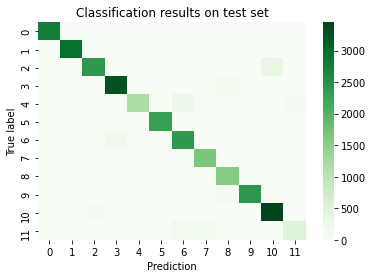

In [17]:
norm_data_model = create_model(250, train_x.shape[2])
norm_data_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history_norm  = norm_data_model.fit(train_x, train_y, epochs=30, batch_size=1024, validation_split=0.2)
save_model(norm_data_model, "norm_data_model")
plot_hisotry (history_norm)
confusion_matrix_predict(norm_data_model, train_x, train_y )